In [38]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

import sys
import os
# sys.path.append("/Users/clemens/Documents/cour ses/DS-Lab/Baselines")
#sys.path.append("/home/elvis/MEGA/ETH/Projects/DSLab/DSLab-StackOverflow/Baselines")

# import gp_features

In [39]:
def available_runs(folder):
    assert(os.path.isdir(folder))
    
    all_files = os.listdir(folder)
    run_files = sorted([f for f in all_files if f[:11] == 'run_summary'])
    print("Available run summaries>>> \n {}".format(run_files))
    
    with_full_path = [os.path.join(folder, f) for f in run_files]
    return with_full_path




In [40]:
runs = available_runs("../cache/gp/runs")
# runs = available_runs(os.environ['SCRATCH'] + "/runs")

with open(runs[-1], "rb") as f:
    summary = pickle.load(f)
    
print(summary.keys())
print(summary['params'])
info = summary['gp_run_info']
used_from_gp = summary['used_questions']
# used_from_gp = pd.read_csv("../Baselines/events_used_by_gp.csv")
# info = pd.read_csv("../Baselines/gp_run_info_dict.csv")
# used_from_gp.loc[:, 'answer_id'] = info.answer_id
# used_from_gp.loc[:, 'predicted_for_user'] = info.user_id
# assert(len(info)==len(used_from_gp))

Available run summaries>>> 
 ['run_summary_12_07__11_11.pickle', 'run_summary_12_07__11_16.pickle', 'run_summary_12_07__22_02.pickle', 'run_summary_12_08__15_25.pickle', 'run_summary_12_08__16_30.pickle']
dict_keys(['used_questions', 'training_set_for_gp', 'gp_run_info', 'params', 'all_mus', 'all_sigmas'])
{'model_choice': 'osgpr', 'm': 100, 'kernel': 'linear', 'k_var': 1.0, 'k_len': 0.8, 'pretrain_steps': 50, 'opt_steps': 20, 'verbose_opt': 'pretraining', 'save_n_neg': 1, 'only_use_features': 'votes_sd affinity_sum tag_popularity votes_mean question_age', 'sum_file_path': '../cache/gp/runs/', 'save_every_n': 100, 'redo_pretraining': False, 'cache_file_path': '../cache', 'log_mu_sigma': True}


In [42]:
summary["all_mus"]
summary["all_sigmas"]

{Timestamp('2015-01-01 00:26:32.347000'): array([0.00707191, 0.00706015, 0.00707329, 0.00706903, 0.00707968,
        0.00706838, 0.0071163 , 0.00707862, 0.00707854, 0.0070614 ,
        0.00710802, 0.00707471, 0.00708708, 0.00707317, 0.00708769,
        0.00722184, 0.00708043, 0.00708978, 0.00708617, 0.00707559,
        0.00707228, 0.00708622, 0.00704161, 0.00710023]),
 Timestamp('2015-01-01 04:24:47.033000'): array([0.00736403, 0.04576289, 0.00769805, 0.0120743 , 0.00710934,
        0.04135851, 0.00752124, 0.00753307, 0.00728224, 0.02403449,
        0.00818551, 0.02490716, 0.01726243, 0.0072961 , 0.03086234,
        0.00709195, 0.00707364, 0.00711378, 0.00751974, 0.00706877,
        0.00742624]),
 Timestamp('2015-01-01 08:42:21.977000'): array([0.0070725 , 0.00707276, 0.00707944, 0.00707154, 0.00707731,
        0.00707107, 0.00707739, 0.00707202, 0.00707371, 0.0070757 ,
        0.00707492, 0.0070786 , 0.00707487, 0.0070741 , 0.00707896,
        0.00707929, 0.00707343, 0.00707356, 0.007

In [48]:
used_from_gp

,question_id,question_date,question_body,question_owner_user_id,question_title,question_tags,question_closed_date,date_of_accepted_ans,event_time,target_user,label
17036,130859,2014-12-31 22:58:24.703,<p>I am trying to prep myself for data science...,48876.0,Linear Regression - Error Term Variance - Numb...,<regression><self-study>,NaT,2015-01-01 00:26:32.347,2015-01-01 00:26:32.347,61496,1.0
17052,130861,2014-12-31 23:47:29.943,<p>Consider a Bernoulli random variable $X\in\...,7025.0,Fisher information matrix determinant for an o...,<bernoulli-distribution><parameterization><fis...,NaT,2015-01-02 13:35:02.547,2015-01-01 00:26:32.347,61496,0.0
17031,130825,2014-12-31 13:53:09.920,"<p>Question about the Total, Explained, and Re...",10812.0,Sum of Square decomposition,<regression><mathematical-statistics><linear-m...,NaT,2014-12-31 15:12:10.123,2015-01-01 04:24:47.033,28746,0.0
17038,130867,2015-01-01 08:12:07.280,"<p>What are the differences between ""inference...",26881.0,Inference vs. estimation?,<machine-learning><inference><terminology>,NaT,2015-01-01 09:33:04.087,2015-01-01 08:42:21.977,36604,0.0
17037,130846,2014-12-31 20:08:08.767,<p>I have trained a SVM with 18881 features an...,36604.0,Getting less number of features in weight vect...,<r><svm><feature-selection><ranking>,NaT,2015-01-01 08:42:21.977,2015-01-01 08:42:21.977,36604,1.0
...,...,...,...,...,...,...,...,...,...,...,...
17254,133268,2015-01-13 18:42:29.713,"<p>For a given density function, how does one ...",66502.0,Get probability distribution function from den...,<probability><distributions><self-study><pdf><...,NaT,2015-01-13 18:56:00.943,2015-01-14 17:07:39.230,7224,0.0
17270,133369,2015-01-14 12:47:34.280,<p>Conceptually I grasp the meaning of the phr...,32504.0,"""The total area underneath a probability densi...",<probability><pdf><integral>,NaT,2015-01-14 14:15:00.833,2015-01-14 17:13:23.147,61496,0.0
17277,133396,2015-01-14 16:07:26.603,<p>Consider the polynomial kernel: $$K(\boldsy...,66175.0,Does a polynomial kernel with degree less than...,<svm><kernel-trick><polynomial>,NaT,2015-01-14 17:13:23.147,2015-01-14 17:13:23.147,61496,1.0
17270,133369,2015-01-14 12:47:34.280,<p>Conceptually I grasp the meaning of the phr...,32504.0,"""The total area underneath a probability densi...",<probability><pdf><integral>,NaT,2015-01-14 14:15:00.833,2015-01-14 17:27:04.870,61496,0.0


In [43]:
def compute_chance_success(n_candidates_list, n):
    p = n/np.array(n_candidates_list)
    p[p>1] = 1 # if there n_preds smaller then candidate list
    return p

In [44]:
win_size = 50
info.loc[:, "is_found"] = (info.predicted_rank != -1)*1.0
info.loc[:, "chance_success"] = compute_chance_success(info.n_candidates, 5)
r_mean = info.is_found.rolling(win_size).mean()
c_mean = info.chance_success.rolling(win_size).mean()

In [45]:
info.loc[:, "event_time"] = pd.to_datetime(info.event_time)
time_indx = pd.to_timedelta(info.event_time- info.event_time.min()) / pd.Timedelta(365, 'D')

Text(0.5, 0, 'time from start of online learning [years]')

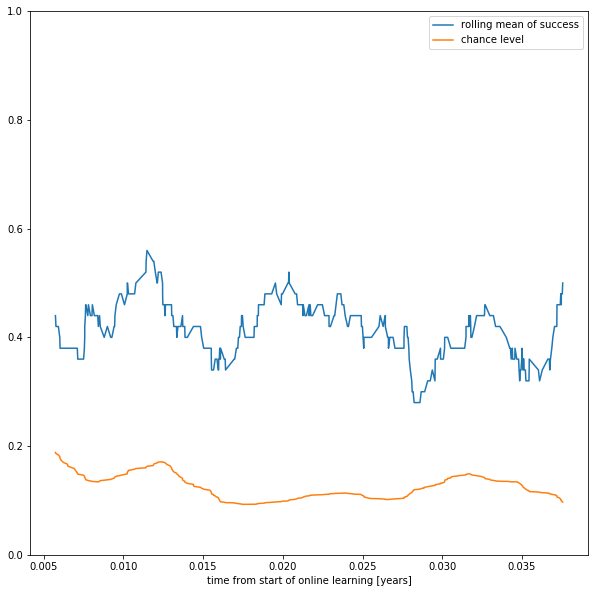

In [46]:
plt.figure(figsize=(10,10))
plt.plot(time_indx.values, r_mean, label='rolling mean of success')
plt.plot(time_indx.values, c_mean, label='chance level')
plt.legend()
plt.ylim(0, 1)
plt.xlabel("time from start of online learning [years]")

(0, 0.5)

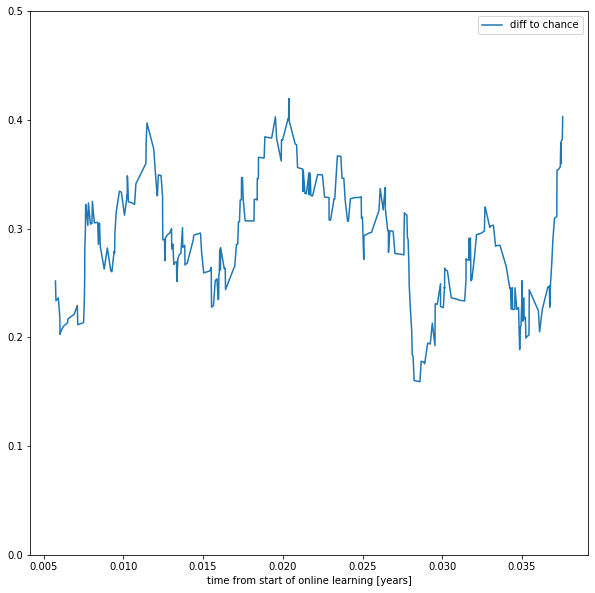

In [47]:
plt.figure(figsize=(10,10))
plt.plot(time_indx.values, r_mean-c_mean, label='diff to chance')
plt.legend()
plt.xlabel("time from start of online learning [years]")
plt.ylim(0, 0.5)

In [8]:
gpr = GaussianProcessRegressor(kernel=DotProduct(), random_state=0, alpha=1e-5)

In [9]:
vals = training_set_for_gp.values
l = np.array(observed_labels)
nnn = 70000
vals, l = vals[nnn:], l[nnn:]
vals.shape

NameError: name 'training_set_for_gp' is not defined

In [12]:
DotProduct()(vals)

array([[42296.        ,  8152.        ,  8152.        , ...,
         5347.        , 17587.        , 17587.        ],
       [ 8152.        ,  8153.00010851,  8153.00010851, ...,
         5347.        ,  5347.        ,  5347.        ],
       [ 8152.        ,  8153.00010851,  8153.00010851, ...,
         5347.        ,  5347.        ,  5347.        ],
       ...,
       [ 5347.        ,  5347.        ,  5347.        , ...,
         3770.        ,  3770.        ,  3770.        ],
       [17587.        ,  5347.        ,  5347.        , ...,
         3770.        ,  8158.        ,  8158.        ],
       [17587.        ,  5347.        ,  5347.        , ...,
         3770.        ,  8158.        ,  8158.        ]])

In [13]:
gpr.fit(vals, l)

GaussianProcessRegressor(alpha=1e-05, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=0)

In [15]:
mu, sigma = gpr.predict(vals[-10:, :], return_std=True)

/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


### OSGPR

In [3]:
used_from_gp = pd.read_csv("../Baselines/events_used_by_gp.csv")
info = pd.read_csv("../Baselines/gp_run_info_dict_osgpr.csv")

In [4]:
used_from_gp.iloc[-35:-25]

,Unnamed: 0,question_id,question_date,question_body,question_owner_user_id,question_title,question_tags,question_closed_date,date_of_accepted_ans,label
23300,120290,86876,2014-02-17 16:12:04.060,<p>We are trying to design a data repository f...,40410.0,Any suggestions for storing diverse data sets ...,<data-visualization><dataset><database>,NaN,NaN,0.0
23301,120290,86876,2014-02-17 16:12:04.060,<p>We are trying to design a data repository f...,40410.0,Any suggestions for storing diverse data sets ...,<data-visualization><dataset><database>,NaN,NaN,0.0
23302,120290,86876,2014-02-17 16:12:04.060,<p>We are trying to design a data repository f...,40410.0,Any suggestions for storing diverse data sets ...,<data-visualization><dataset><database>,NaN,NaN,0.0
23303,120290,86876,2014-02-17 16:12:04.060,<p>We are trying to design a data repository f...,40410.0,Any suggestions for storing diverse data sets ...,<data-visualization><dataset><database>,NaN,NaN,0.0
23304,120290,86876,2014-02-17 16:12:04.060,<p>We are trying to design a data repository f...,40410.0,Any suggestions for storing diverse data sets ...,<data-visualization><dataset><database>,NaN,NaN,0.0
23305,120280,86852,2014-02-17 12:53:58.363,<p>It's quite common to normalise different fe...,9007.0,Normalising higher moments of features for mac...,<machine-learning><normalization>,NaN,NaN,1.0
23306,120290,86876,2014-02-17 16:12:04.060,<p>We are trying to design a data repository f...,40410.0,Any suggestions for storing diverse data sets ...,<data-visualization><dataset><database>,NaN,NaN,0.0
23307,120290,86876,2014-02-17 16:12:04.060,<p>We are trying to design a data repository f...,40410.0,Any suggestions for storing diverse data sets ...,<data-visualization><dataset><database>,NaN,NaN,0.0
23308,12075,86889,2014-02-17 17:14:53.310,<p>I calculated the least-squares means and st...,10339.0,lsmeans vs. differences between lsmeans,<r><statistical-significance><standard-error><...,NaN,2014-02-18 08:39:04.097,0.0
23309,12075,86889,2014-02-17 17:14:53.310,<p>I calculated the least-squares means and st...,10339.0,lsmeans vs. differences between lsmeans,<r><statistical-significance><standard-error><...,NaN,2014-02-18 08:39:04.097,0.0


In [6]:
win_size = 500
info.loc[:, "is_found"] = (info.predicted_rank != -1)*1.0
info.loc[:, "chance_success"] = compute_chance_success(info.n_candidates, 5)
r_mean = info.is_found.rolling(win_size).mean()
c_mean = info.chance_success.rolling(win_size).mean()

In [7]:
info.loc[:, "event_time"] = pd.to_datetime(info.event_time)
time_indx = pd.to_timedelta(info.event_time- info.event_time.min()) / pd.Timedelta(365, 'D')

Text(0.5, 0, 'time from start of online learning [years]')

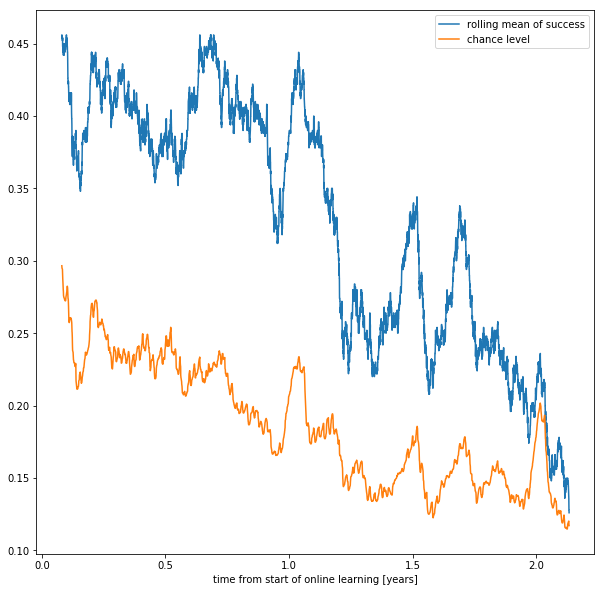

In [8]:
plt.figure(figsize=(10,10))
plt.plot(time_indx.values, r_mean, label='rolling mean of success')
plt.plot(time_indx.values, c_mean, label='chance level')
plt.legend()
plt.xlabel("time from start of online learning [years]")

Text(0.5, 0, 'time from start of online learning [years]')

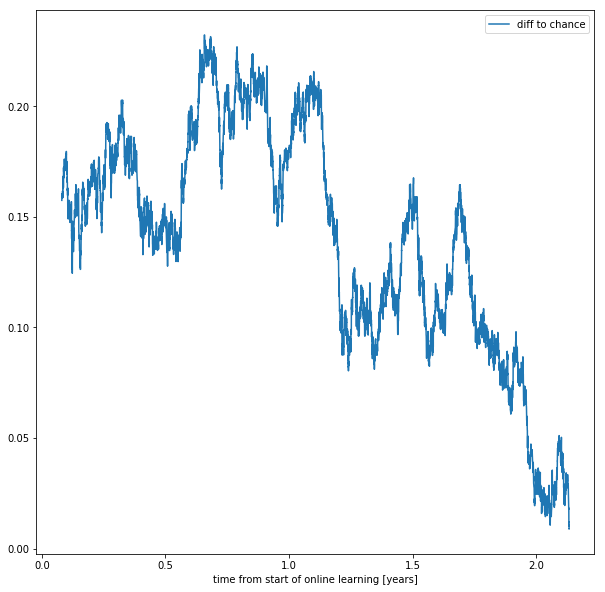

In [9]:
plt.figure(figsize=(10,10))
plt.plot(time_indx.values, r_mean-c_mean, label='diff to chance')
plt.legend()
plt.xlabel("time from start of online learning [years]")